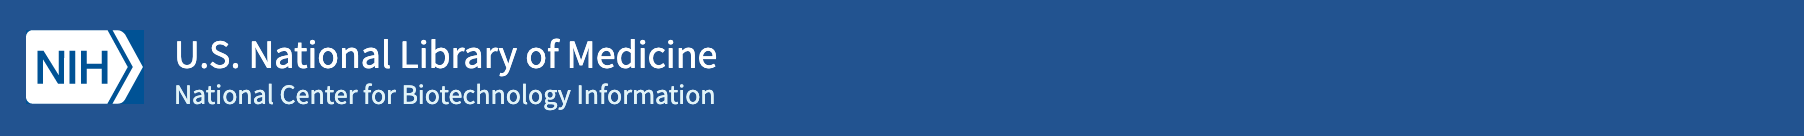

# BLAST on the Command Line and Integrating with Python

In this tutorial, you'll learn how to:
- Run BLAST on sequence data
- Parse the results with Python 
- Convert data to Excel

We will be using this Jupyter notebook for the tutorial. If you see a cell that contains code, you can execute it by clicking on the cell and hitting <b>Shift + Enter</b>. 

<div class="alert alert-block alert-warning">
    <h> <b> A brief primer on Juypter notebooks </b> </h>
<p>Jupyter notebooks make it super easy to experiment with code. It lets you quickly create and execute new lines of code, without having to reprocess data or rerun code. Here are some tips about Jupyter notebooks:
</p>

<p>
    <ul>
        <li>Starting a cell with `!` or `%%bash` directs the cell's contents to the command line shell.
        <li>To run a code cell, click on the cell and then hit <b>Shift+Enter</b>. This keystroke will also move you to the next cell, so hitting it repeatedly will move you through a notebook quickly.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>You can run one cell while another cell is still running. It will add the new command to a queue of commands to process.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing!</li>
    </ul>
</p>
</div>

-----

## Preparing to run BLAST on the command line

Running BLAST on your system's command line typically requires:
- Command line-based BLAST+ applications on a computer
- A database to query
- Sequences to match against the database

This notebook handles the first hurdle: BLAST will work in this environment at launch. (For details, see [here](https://www.ncbi.nlm.nih.gov/books/NBK279671/) for the official documentation; however, [conda makes it easier](https://anaconda.org/bioconda/blast).)

This tutorial handles the second hurdle by creating a custom database. We'll use the FASTA-formatted sequence of *S. cerevisiae* mitochondrial genome to make the database in this simple example. Retrieve that with the command in the next cell.  

Click in the next cell and hit <b>shift-enter</b>.

In [ ]:
!curl -O https://downloads.yeastgenome.org/sequence/S288C_reference/chromosomes/fasta/chrmt.fsa

Now run the code in the next cell to create the database using the downloaded sequence. (For details, see [here](http://library.open.oregonstate.edu/computationalbiology/chapter/command-line-blast/) and [here](https://angus.readthedocs.io/en/2017/ ).)

In [ ]:
!makeblastdb -in chrmt.fsa -dbtype nucl

Now you have indexed database for mitochdondrial chromosome!

Finally, the third hurdle is usually trivial in practice, as you would already have sequences you're querying against the database. In this tutorial, we'll pull some example FASTA-formatted sequences of other mitochondria assembled primarily from long read data, see [Yue et al., 2017 PMID: 28416820](https://www.ncbi.nlm.nih.gov/pubmed/28416820). It will also fix the first line of each of those so they have unique identifiers based on the file name. Otherwise they would all be `chrMT`.

In [ ]:
%%bash
curl -LO http://yjx1217.github.io/Yeast_PacBio_2016/data/Mitochondrial_Genome/S288C.mt.genome.fa.gz
gunzip -f S288C.mt.genome.fa.gz
# Up until sometime around September / October 2018, the above referenced file was named `S288c.mt.genome.fa.gz` on that server and
# I built things around that. The name has since changed to the more-correct `S288C.mt.genome.fa.gz`, but I am going 
# to convert name to earlier form to make subsequent commands work, be more distinguished from SGD S288C reference sequence,
# and make things continue match what was seen before.
mv S288C.mt.genome.fa S288c.mt.genome.fa
curl -LO http://yjx1217.github.io/Yeast_PacBio_2016/data/Mitochondrial_Genome/SK1.mt.genome.fa.gz
gunzip -f SK1.mt.genome.fa.gz
curl -LO http://yjx1217.github.io/Yeast_PacBio_2016/data/Mitochondrial_Genome/Y12.mt.genome.fa.gz
gunzip -f Y12.mt.genome.fa.gz
var=$(echo "S288c.mt.genome.fa" | cut -d'.' --complement -f2-).mito
sed -i "1s/.*/>$var/" S288c.mt.genome.fa
var=$(echo "SK1.mt.genome.fa" | cut -d'.' --complement -f2-).mito
sed -i "1s/.*/>$var/" SK1.mt.genome.fa
var=$(echo "Y12.mt.genome.fa" | cut -d'.' --complement -f2-).mito
sed -i "1s/.*/>$var/" Y12.mt.genome.fa

Now you are prepared to run BLAST on the command line.



## Running BLAST on the command line (basics)

We'll start by running one of the sequences against the database with the following command. Be warned, it will output a lot of data!

In [ ]:
!blastn -query S288c.mt.genome.fa -db chrmt.fsa

We're about to learn how to use Python to parse through these results. But let's quickly suppose you don't want to use Python. One workaround is to direct the output to a file, as the next command does.

In [ ]:
!blastn -query S288c.mt.genome.fa -db chrmt.fsa -out S288C.mt.x.chrmt.txt

As a quick aside, note that the command above left a lot of decisions to the software or the defaults programmed into the software. However, you don't need to accept those defaults and can adjust things as needed. Here is an example command were we use what are called 'flags' to provide parameters for various settings.

In [ ]:
!blastn -query S288c.mt.genome.fa -db chrmt.fsa -task blastn -gapopen 5 -gapextend 2 -reward 2 -penalty -3 -word_size 11 -out flag_example.txt

<div class="alert alert-block alert-warning">
    
<p> The Tables <a href='https://www.ncbi.nlm.nih.gov/books/NBK279684/'>here</a> are particularly helpful for understanding what those flags mean. Briefly, we controlled a lot of the settings BLAST uses, and you'll note this query is computationally much more demanding than `!blastn -query S288c.mt.genome.fa -db chrmt.fsa -out S288C.mt.x.chrmt.txt`. I just wanted to touch on this ability here; you can explore this further in this binder with your own sequences. However, because experimenting with these settings can generate a lot of data, you may wish to return to trying things after learning how to use Python's tools. </p>

<p> Note: If you are not seeing hits, you may be using too stringent of setings as megblast is the default currently run with the command `blastn` as discussed in <a href='http://www.sixthresearcher.com/when-blast-is-not-blast/'>this post</a>. You probably want `-task blastn` included. </p>
</div>

Great! Now recall that we had just created a file from our query. It turns out that you can easily view portions of this file right from the command line. For example, you can view the first 45 lines by running the next command.

In [ ]:
!head -45 S288C.mt.x.chrmt.txt

That shows that there is a 57 kb fragment that matches very well the sequence we used to build the database.

Likewise `tail` could be used and combinations to look at parts of the file, like in the next cell.

In [ ]:
!tail -21979 S288C.mt.x.chrmt.txt | head -45

All these command line tools are really clunky! Python provides much better tools for reading BLAST results.




## Running BLAST on the command line and sending the output to parseable files

We would like the computer to efficiently parse our data. A human-readable form isn't the most efficient form for a computer. Instead, we'll build on an [approach](https://medium.com/@auguste.dutcher/turn-blast-results-into-a-presence-absence-matrix-cc44429c814) that involves using 'flags' to control the settings as just discussed above. (For details about flags, see [here](https://blastedbio.blogspot.com/2014/11/column-headers-in-blast-tabular-and-csv.html).)

Run the next cell to make a new file `S288C.mt.x.chrmt.c.txt`.

In [ ]:
!blastn -query S288c.mt.genome.fa -db chrmt.fsa -outfmt "6 qseqid sseqid stitle pident qcovs length mismatch gapopen qstart qend sstart send qframe sframe frames evalue bitscore qseq sseq" -task blastn -out S288C.mt.x.chrmt.c.txt


Let's peek at what that looks like by looking at the first line.

In [ ]:
!head -1 S288C.mt.x.chrmt.c.txt

You'll notice that definitely look different, and we've moved away from 'human-readable' data.

Next, we'll use Python, which is great for working with text-based data to parse this into a much more convenient form. Plus, we'll make it human-readable at the same time!

## Integrating BLAST results with Python (and visualizations!)

We are going to use dataframes to handle the results. These are a really convenient and popular datatype (Python even has an entire library, Pandas, for dealing with them!). We'll use a script (which uses Pandas) to take the BLAST results and make them into a dataframe. 

To get that script, you can run the next cell.

In [ ]:
!curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/blast-utilities/blast_to_df.py

We have the script now. And we already have a file for it to process! The next command runs the script and directs it at the results file, `S288C.mt.x.chrmt.c.txt`, we made just a few cells ago.

In [ ]:
%run blast_to_df.py S288C.mt.x.chrmt.c.txt

At this time, the script outputs a file that is a binary, compact form of the dataframe. (This is not human-readable.)

We can take that file where the dataframe is pickled, and bring it into active memory in this notebook with another command form the Pandas library. First we have to import the Pandas library (`blast_to_df.py` from the last cell ran in a different computational environment than the one associated with this notebook).

Run the next command to bring the dataframe into active memory.

In [ ]:
import pandas as pd
df = pd.read_pickle("BLAST_pickled_df.pkl")

When that last cell ran, you won't notice any output, but something happened. We can look at that dataframe by calling it in a cell.

In [ ]:
df

You'll notice that it is so large, that the Jupyter environment represents just the head and tail to make it more reasonable.

Dataframes also have tools to view them on the command line. For example, you can use the `head` method to see its start.

In [ ]:
df.head()

We can also use visualizations to interpret the data more easily. First, we'll use the plotly library to how the values in each entry relate to each other. We'll also add special emphasis to the entries with the best pident values.

In [ ]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

data = [
    go.Parcoords(
        line = dict(color = df['pident'],
                    colorscale=[[0,'#d6d7d9'],[0.8,'#e59393'],[1,'#e31c3d']],
                    colorbar={'tickvals': [df['pident'].max(), df['pident'].min()],
                             },
                    showscale=False),
        dimensions = list([
            dict(range = [0,100],
                 label = 'pident', values = df['pident']),
            dict(range = [0,df['mismatch'].max()],
                 label = 'mismatch', values = df['mismatch']),
            dict(range = [0,df['gapopen'].max()],
                 label = 'gapopen', values = df['gapopen']),
            dict(range = [0,df['length'].max()],
                 label = 'length', values = df['length']),
            dict(range = [0,df.bitscore.max()],
                 label = 'bitscore', values = df['bitscore']),
        ])
    )
]

init_notebook_mode(connected=True)
iplot(data, filename = 'blast_results_fig')

We can also explore the relationship between two aspects of the data more closely. For example, here's a scatterplot showing pident vs. mismatch in our results.

In [ ]:
trace = go.Scatter(
            x=list(df['mismatch']),
            y=list(df['pident']),
            mode = 'markers')
data = [trace]
iplot(data, filename = 'scatter')

Let's run BLAST again with different data, and bring the results into a dataframe in a more direct way. The next cell will run another BLAST and make the data in a dataframe.

<div class="alert alert-block alert-warning">

This depends on running the ['Preparation' section above](#Preparing-to-run-BLAST-on-the-command-line) and additionally the following two commands from above:

- `!curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/blast-utilities/blast_to_df.py`
- `import pandas as pd`  

And so if you are picking this back up later, run [the first section](#Preparing-to-run-BLAST-on-the-command-line) and then add two cells and run the two commands above.)

</div>



In [ ]:
!blastn -query Y12.mt.genome.fa -db chrmt.fsa -outfmt "6 qseqid sseqid stitle pident qcovs length mismatch gapopen qstart qend sstart send qframe sframe frames evalue bitscore qseq sseq" -task blastn -out Y12.mt.x.chrmt.c.txt
%run blast_to_df.py Y12.mt.x.chrmt.c.txt --df_output next_BLAST_pickled_df.pkl
df = pd.read_pickle("next_BLAST_pickled_df.pkl")
df.head()

## Demonstrating the Utility of Having the BLAST Results in Python


Now we'll then demonstrate the utility of the dataframe form with an applied example demonstrating the ease with which you can extract relevant data using Pandas.

Let's use a real-world example. Curating researchers define the "start" position of the circular chromosome differently from the arbitrary "start" that the Saccharomyces Genome Database (SGD) uses for the S288C mitochdonrial start position. For comparing the position of genes, it is important to be able to match these other sequences to the SGD reference sequence.

In most cases, the "start" used by the curating researchers is easily located from the BLAST data by finding the segment that matches the start of the SGD sequence. That translates to wanting to find where the value in the `sstart` (subject start) column matches 1. For the PacBio S288C that we looked at in the first example above, the second row in the result viewable `df.head()` revealed that. But it didn't here. We can find it easily though via the power of Pandas by coding a conditional selection to say we want any rows there `sstart` equals `1`. The next cell will run this subsetting operation.

In [ ]:
start_loc_df = df[df['sstart']==1]
start_loc_df

Running that reveals the answer, the `qstart`(query start) position of 54123 matches the SGD reference sequence position 1.
In fact, we can extract that exact value using Pandas. We'll assign that to a variable for future use. Additionally we are going to make sure we sort the `start_loc_df` on `bitscore`. This sorting is important because if there were two matches satisfying `df['sstart']==1`, we should take the better scoring one.

In [ ]:
start_loc_df = start_loc_df.sort_values(['sstart','bitscore'],ascending=[1,0])
start_loc = start_loc_df.iloc[0]["qstart"]
start_loc

So now you have `start_loc` defined as the position in the PacBio Y12 mitochondrial sequence as the one that matches the SGD sequence. In the next cell, we adjust the sequence of the PacBio Y12 mitochondrial sequence to match the 'start' position SGD uses.

In [ ]:
from Bio import SeqIO
with open("Y12.mt.genome.fa") as handle:
    mito_seq = SeqIO.read(handle, "fasta")

# fix, based on where it says "i.e. shift the starting point on this plasmid," @ 
#http://biopython.org/DIST/docs/api/Bio.SeqRecord.SeqRecord-class.html
left = mito_seq[:start_loc-1] # use one less because of zero indexing in Python
right = mito_seq[start_loc-1:]
new_mito_seq = right + left

# write result after fix
SeqIO.write(
    new_mito_seq, "Y12.mt.genome.START_ADJUSTED.fa", "fasta");

The saved sequence `Y12.mt.genome.START_ADJUSTED.fa` should begin at that same point, and now it would be ready for use with the SGD reference sequence (available [here](https://downloads.yeastgenome.org/sequence/S288C_reference/chromosomes/fasta/chrmt.fsa) or already downloaded into this active Jupyter environment as `chrmt.fsa` in the course of the preparation steps) in an alignment by [Kalign](https://www.ebi.ac.uk/Tools/msa/kalign/). If you were to do that, you'd see the both ends of that long alignment actually align.

(To get to the dashboard where the file directory is visible, click on the Jupyter logo in the upper left of this notebook page.)

If we had tried running the alignment without moving the parts to match the SGD sequence, the sequences would align in the 'middle', but the two 'ends' would be left overhanging (that's thousands of base pairs on each end!). 

You can demonstrate those two situations I just described easily for yourself with the sequences available in this Jupyter environment by submitting them to [Kalign](https://www.ebi.ac.uk/Tools/msa/kalign/).

**Another way**
    
Of course, you can work with tabular BLAST output other ways. For example, AWK used on the command line can easily grab the best hit as described here by Mick Watson:

>"Also if you have multiline tabular BLAST results, just get top hit by
awk '!a[$1]++'"  
-Source: https://twitter.com/BioMickWatson/status/1017486331511963648
    
Demonstrating that:

In [ ]:
!cat S288C.mt.x.chrmt.c.txt|awk '!a[$1]++'

## Practical BLAST: Have related sequences to be queried in same file

Above we dealt with PacBio-generated sequences S228C and then Y12, comparing them the SGD reference sequence for S288C. However, it is much better to combine the asociated sequences into one file and submit it in one BLAST job. As you'll see, the dataframe structure makes it easy to keep these combined, but individually accessible. This enhances reproducibility because you then have one master file to deal with and you know you had the same settings applied to all the involved queries. This is espeically important once you start using 'flags' to customize settings.

Let's combine all the PacBio data we have been dealing with above, along with a new one. First we'll concatenate all the individual FASTA files we were dealing with into one file, which will consist of multiple squences in FASTA format (i.e. Multi-FASTA format). 

<div class="alert alert-block alert-warning">
As with the last section, the next cell working will depend on running the ['Preparation' section above](#Preparing-to-run-BLAST-on-the-command-line) and additionally the following two commands from above:

- `!curl -O https://raw.githubusercontent.com/fomightez/sequencework/master/blast-utilities/blast_to_df.py`
- `import pandas as pd`  

If you are picking this back up later, run [the first section](#Preparing-to-run-BLAST-on-the-command-line) and then add two new cells and run the two commands above.
</div>

In [ ]:
!cat S288c.mt.genome.fa Y12.mt.genome.fa SK1.mt.genome.fa > pacbio.mt.fa
!blastn -query pacbio.mt.fa -db chrmt.fsa -outfmt "6 qseqid sseqid stitle pident qcovs length mismatch gapopen qstart qend sstart send qframe sframe frames evalue bitscore qseq sseq" -task blastn -out pacbio.mt.x.chrmt.c.txt
%run blast_to_df.py pacbio.mt.x.chrmt.c.txt --df_output pb.x.chrmt_pickled_df.pkl
df = pd.read_pickle("pb.x.chrmt_pickled_df.pkl")
df.head()

Promising. But the `qseqid`(query sequence identifier) only shows data for the part of `S288c.mito` visible right now. Let's run the `df.tail()` command next.

In [ ]:
df.tail()

The new data is `SK1.mito` is also in there! We can easily access individual parts by adding conditions based on the `qseqid` to selections for the dataframe filtering/subsetting.

For example, earlier we got the 'start' value for Y12 corresponding to position #1 of the SGD sequence. You can repeat that for SK1 by running the next cell.

In [ ]:
SK1_df = df[df['qseqid'] == "SK1.mito"]
start_loc_df = SK1_df.sort_values(['sstart','bitscore'],ascending=[1,0])
start_loc = start_loc_df.iloc[0]["qstart"]
start_loc

You can see that more in context by showing the start of the pertinent dataframe.

In [ ]:
start_loc_df.head()

Once again, you could adjust the sequence based on that number so the 'starts' match. From what we've just done, it's clear that `pb.x.chrmt_pickled_df.pkl` is easier to generate and much better to deal with than the individual approaches I had done earlier.

## Output to more universal, table-like formats

I've tried to sell you on the power of the Python/Pandas dataframe. But if you insist on using Excel, we can also work with text-based tables.

Python/Pandas makes it easy to go from the dataframe form to these tabular forms. Run the cell below to create a text-based table, where the entries are separated by commas.

In [ ]:
#Save / write a TSV-formatted (tab-separated values/ tab-delimited) file
df.to_csv('blast_data.tsv', index = False) #add `,header=False` to leave off header, too

Alternatively, you can run the cell below to create a text-based table, where the entries are separated by tabs.

In [ ]:
#Save / write a TSV-formatted (tab-separated values/ tab-delimited) file
df.to_csv('blast_data.tsv', sep='\t',index = False) #add `,header=False` to leave off header, too

We can confirm this worked by looking at the first line with the next command.

In [ ]:
!head -1 blast_data.tsv

If you need to convert a comma-separated file to a dataframe, you can run the following cell.

In [ ]:
reverted_df = pd.read_csv('blast_data.tsv')
reverted_df.to_pickle('reverted_df.pkl') # OPTIONAL: pickle that data too

If you had need to go back from a tab-separated table to a dataframe, you can run something like in the following cell.

In [ ]:
reverted_df = pd.read_csv('blast_data.tsv', sep='\t')
reverted_df.to_pickle('reverted_df.pkl') # OPTIONAL: pickle that data too

You can verify that read from the text-based table by viewing it with the next line.

In [ ]:
reverted_df.head()

**Generating an Excel spreadsheet from a dataframe.**

The next cell installs a package to assist with Excel comptability.

In [ ]:
!pip install openpyxl
# save to excel (KEEPS multiINDEX, and makes sparse to look good in Excel straight out of Python)
df.to_excel('blast_data.xlsx') # after openpyxl installed

There is no viewer in Juypter, so you will need to download the file and view it locally. Additionally, you can add styles to dataframes (e.g. shading cells and coloring text) and they will be translated to the Excel document.

Excel files can also be read in to dataframes directly using the `xlrd` module.

In [ ]:
!pip install xlrd
# read Excel, after xlrd installed
df_from_excel = pd.read_excel('blast_data.xlsx', encoding = 'utf8') # after xlrd installed 

Run the next line to convince yourself it worked.

In [ ]:
df_from_excel.head()

-----

## Where to next?

Now you know the basics of working with BLAST and its output. Try applying these techniques to your own data!

You can get to the Jupyter dashboard by clicking the the Jupyter logo in the upper left corner of this notebook. There you can upload files from your computer. You can also launch a new notebook from there, which preserves this session's work.

Note that if you create useful files, you should save them ASAP -- these MyBinder instances are temporary! Also remember to save the pickled dataframe files, as they can be read in again to continue analysis without re-rerunning any BLAST.

Next steps including learning more about 'flags' (mentioned earlier) and Pandas (see resources below).

- [Chris' Albon Data Wrangling has a lot of concise Pandas recipes](https://chrisalbon.com/python/data_wrangling/) , search 'pandas' in that list
- [10 Minutes to pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
- [Pandas Intro](http://www.stephaniehicks.com/learnPython/pages/pandas.html) 
- [Shane Lynn's Using iloc, loc, & ix to select rows and columns in Pandas DataFrames](https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/)
- [My gist of useful Pandas snippets](https://gist.github.com/fomightez/ef57387b5d23106fabd4e02dab6819b4)
- [Things in Pandas I Wish I'd Known Earlier](http://nbviewer.jupyter.org/github/rasbt/python_reference/blob/master/tutorials/things_in_pandas.ipynb)


There is also [another notebook, entitled 'BLAST on the Command Line with Advanced Python' here](BLAST%20on%20the%20Command%20Line%20with%20Advanced%20Python.ipynb#BLAST-on-the-Command-Line-with-Advanced-Python), which shows how to streamline these processes in Juypter. For example, you don't need to rely on file intermediates. If you are using Jupyter notebooks, you should definitely check this out.


**The Binder-luanchable version that you are using here too limiting for your needs?**

NCBI has [made available](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=CloudBlast) an Amazon Machine Image (AMI) that will generate a remote cloud compute instance already set to run standalone BLAST. Additional documentation is [here](http://ncbi.github.io/blast-cloud/). 

-----

**CREDITS/RESOURCES**:

The contents of this tutorial are largely drawn from [Wayne's Bioinformatics Code Portal Blast Binder](https://github.com/fomightez/blast-binder). He cites the following sources.

<div class="alert alert-block alert-warning">

<p> The portions dealing with running BLAST on command line are based on: </p>
<p>
    <ul>
        <li><a href="https://angus.readthedocs.io/en/2017/running-command-line-blast.html">Titus Brown's Running command-line BLAST</a> - from 2017 (early 2019 version with R for downstream <a href="https://hackmd.io/FVzYhD6lRoOPFFZvW2GAGw?view">here</a>)</li>
        <li><a href="http://library.open.oregonstate.edu/computationalbiology/chapter/command-line-blast/">Shawn  T. O’Neil's A Primer for Computational Biology: Chapter 7 Command Line BLAST</a></li>
    </ul>
</p>
<p>
    See <a href="https://medium.com/@auguste.dutcher/turn-blast-results-into-a-presence-absence-matrix-cc44429c814">here</a> for illustration of the approach used for feeding the results into Python, and <a href="https://blastedbio.blogspot.com/2014/11/column-headers-in-blast-tabular-and-csv.html">here</a> for a listing of explanations for the text codes involved in the flags. Using <a href="https://github.com/widdowquinn/Teaching-SfAM-ECS/blob/61ee5e98e7c1327cfc2bfc2ca6e44c2bdefcaeed/workshop/02b-blast.ipynb">NCBI BLAST+ Service with Biopython</a> might also be of interest. </p>
<p>
    The Tables <a href="https://www.ncbi.nlm.nih.gov/books/NBK279684/">here</a> are particularly useful for enhancing your queries with custom options.</p>
<p>
My script <a href="https://github.com/fomightez/sequencework/blob/master/blast-utilities/blast_to_df.py">`blast_to_df.py`</a> is used as well and can be found in my <a href="https://github.com/fomightez/sequencework/tree/master/blast-utilities">blast-utilities repository</a>.</p>
</div> 

----